# **Transfer Learning**

For many of the problems you'll want to use deep learning for, chances are, a working model already exists.

And the good news is, you can access many of them on TensorFlow Hub (https://tfhub.dev/).

TensorFlow Hub is a repository for existing model components. It makes it so you can import and use a fully trained model with as little as a URL.

In [1]:
# Are we using a GPU?
!nvidia-smi

Tue Nov  1 10:34:58 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## **Geting data**

In [2]:
# Get data (10% of labels)
import zipfile

# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2022-11-01 10:37:20--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.128, 142.251.10.128, 142.251.12.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  55.4MB/s    in 2.9s    

2022-11-01 10:37:24 (55.4 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [4]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing images:")
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


**Setting up callbacks (things to run whilst our model trains)**

Before we build a model, there's an important concept we're going to get familiar with because it's going to play a key role in our future model building experiments.

And that concept is callbacks.

Callbacks (https://www.tensorflow.org/api_docs/python/tf/keras/callbacks) are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks include:

* **Experiment tracking with TensorBoard** - log the performance of multiple models and then view and compare these models in a visual way on TensorBoard (a dashboard for inspecting neural network parameters). Helpful to compare the results of different models on your data.
* **Model checkpointing** - save your model as it trains so you can stop training if needed and come back to continue off where you left. Helpful if training takes a long time and can't be done in one sitting.
* **Early stopping** - leave your model training for an arbitrary amount of time and have it stop training automatically when it ceases to improve. Helpful when you've got a large dataset and don't know how long training will take.

We'll explore each of these overtime but for this notebook, we'll see how the TensorBoard callback can be used.

The TensorBoard callback can be accessed using tf.keras.callbacks.TensorBoard().

Its main functionality is saving a model's training performance metrics to a specified log_dir.

By default, logs are recorded every epoch using the update_freq='epoch' parameter. This is a good default since tracking model performance too often can slow down model training.

In [5]:
# Create tensorboard callback (functionized because need to create a new one for each model)
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

Because you're likely to run multiple experiments, it's a good idea to be able to track them in some way.

In our case, our function saves a model's performance logs to a directory named [dir_name]/[experiment_name]/[current_timestamp], where:

* dir_name is the overall logs directory
* experiment_name is the particular experiment
* current_timestamp is the time the experiment started based on Python's datetime.datetime().now()

🔑 Note: Depending on your use case, the above experimenting tracking naming method may work or you might require something more specific. The good news is, the TensorBoard callback makes it easy to track modelling logs as long as you specify where to track them. So you can get as creative as you like with how you name your experiments, just make sure you or your team can understand them.

## Creating Models using TensorFlow Hub

In the past we've used TensorFlow to create our own models layer by layer from scratch.

Now we're going to do a similar process, except the majority of our model's layers are going to come from TensorFlow Hub.

In fact, we're going to use two models from TensorFlow Hub:

* ResNetV2 - a state of the art computer vision model architecture from 2016.
* EfficientNet - a state of the art computer vision architecture from 2019.

we're going to use:https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1. However, it is necessary mentioning why we use feature extraction models instead of classification models.

**"As is" transfer learning** is when you take a pretrained model as it is and apply it to your task without any changes.
* For example, many computer vision models are pretrained on the ImageNet dataset which contains 1000 different classes of images. This means passing a single image to this model will produce 1000 different prediction probability values (1 for each class).

* This is helpful if you have 1000 classes of image you'd like to classify and they're all the same as the ImageNet classes, however, it's not helpful if you want to classify only a small subset of classes (such as 10 different kinds of food). Model's with "/classification" in their name on TensorFlow Hub provide this kind of functionality.

**Feature extraction transfer learning** is when you take the underlying patterns (also called weights) a pretrained model has learned and adjust its outputs to be more suited to your problem.
* For example, say the pretrained model you were using had 236 different layers (EfficientNetB0 has 236 layers), but the top layer outputs 1000 classes because it was pretrained on ImageNet. To adjust this to your own problem, you might remove the original activation layer and replace it with your own but with the right number of output classes. The important part here is that only the top few layers become trainable, the rest remain frozen.

* This way all the underlying patterns remain in the rest of the layers and you can utilise them for your own problem. This kind of transfer learning is very helpful when your data is similar to the data a model has been pretrained on.

In [6]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [7]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [8]:
def create_model(model_url, num_classes=10):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  
  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape
  
  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer      
  ])

  return model

In [9]:
# Create model
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)

# Compile
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

We can add a callback to our model by using the callbacks parameter in the fit function.

In [11]:
# Fit the model
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="resnet50V2")]) # name of log files

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20221101-105644
Epoch 1/5
24/24 [==============================] - 29s 759ms/step - loss: 1.7972 - accuracy: 0.3933 - val_loss: 1.1273 - val_accuracy: 0.6468
Epoch 2/5
24/24 [==============================] - 16s 672ms/step - loss: 0.8429 - accuracy: 0.7533 - val_loss: 0.8206 - val_accuracy: 0.7444
Epoch 3/5
24/24 [==============================] - 16s 668ms/step - loss: 0.5856 - accuracy: 0.8480 - val_loss: 0.7185 - val_accuracy: 0.7732
Epoch 4/5
24/24 [==============================] - 16s 676ms/step - loss: 0.4472 - accuracy: 0.8880 - val_loss: 0.6844 - val_accuracy: 0.7764
Epoch 5/5
24/24 [==============================] - 16s 678ms/step - loss: 0.3634 - accuracy: 0.9200 - val_loss: 0.6588 - val_accuracy: 0.7852


In [12]:
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

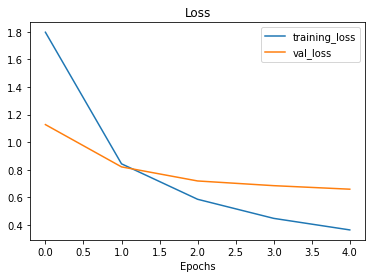

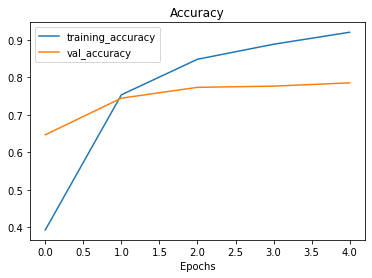

In [13]:
plot_loss_curves(resnet_history)

In [16]:
# Resnet summary 
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [14]:
# Create efficent net model
efficientnet_model = create_model(model_url=efficientnet_url, # use EfficientNetB0 TensorFlow Hub URL
                                  num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model 
efficientnet_history = efficientnet_model.fit(train_data_10_percent, # only use 10% of training data
                                              epochs=5, # train for 5 epochs
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", 
                                                                                     # Track logs under different experiment name
                                                                                     experiment_name="efficientnetB0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20221101-110408
Epoch 1/5
24/24 [==============================] - 26s 713ms/step - loss: 1.7832 - accuracy: 0.4733 - val_loss: 1.2530 - val_accuracy: 0.7360
Epoch 2/5
24/24 [==============================] - 15s 642ms/step - loss: 1.0322 - accuracy: 0.7760 - val_loss: 0.8456 - val_accuracy: 0.8152
Epoch 3/5
24/24 [==============================] - 15s 641ms/step - loss: 0.7436 - accuracy: 0.8360 - val_loss: 0.6901 - val_accuracy: 0.8400
Epoch 4/5
24/24 [==============================] - 15s 642ms/step - loss: 0.5981 - accuracy: 0.8787 - val_loss: 0.6051 - val_accuracy: 0.8524
Epoch 5/5
24/24 [==============================] - 15s 643ms/step - loss: 0.5068 - accuracy: 0.8893 - val_loss: 0.5530 - val_accuracy: 0.8628


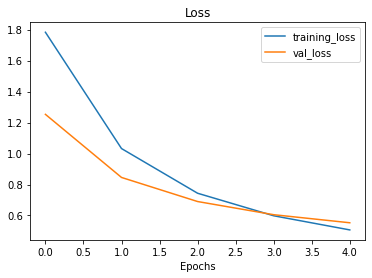

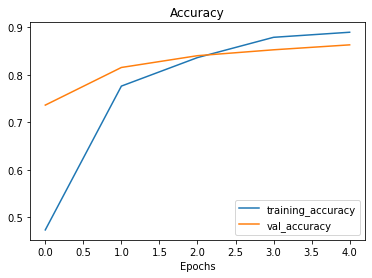

In [15]:
plot_loss_curves(efficientnet_history)

In [17]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


## Comparing models with TensorBoard

You can compare the performance of our two models by looking at the accuracy scores. To visualize them, we can upload the results to TensorBoard.dev.

In [18]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \
  --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=kyb9aG9SsYop0M8AbEWK7XBhT4Fz6Y&prompt=consent&access_type=off

In [19]:
# Check out experiments
!tensorboard dev list

https://tensorboard.dev/experiment/t1CjeVNBRjmH0douB47zAQ/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction models architectures using 10% of training images
	Id                   t1CjeVNBRjmH0douB47zAQ
	Created              2022-11-01 11:16:28 (38 seconds ago)
	Updated              2022-11-01 11:16:32 (34 seconds ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5918466
Total: 1 experiment(s)


In [ ]:
#tensorboard dev delete --experiment_id [INSERT_EXPERIMENT_ID]